In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gpytorch
from gpytorch import means, kernels, likelihoods, distributions, lazy, mlls
from linear_operator.utils.cholesky import psd_safe_cholesky
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
import xarray as xr
import tqdm
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'text.usetex': False,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.fair import run, get_params
from src.fair.ancil import get_gas_params, get_thermal_params
from src.preprocessing import load_emissions_dataset, load_response_dataset
from src.models import ThermalBoxesGP, ExactGP
from src.structures import Scenario, ScenarioDataset
from src.preprocessing import load_emissions_dataset, load_response_dataset
import notebooks.utils_spatial as spatial
import notebooks.utils as utils

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return 

<IPython.core.display.Javascript object>

In [3]:
# Compute reference spatial pattern for temperature anomaly
keys = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in keys}
all_tas = xr.concat([ds.tas for ds in outputs.values()], dim='time').mean(['member'])
weight = np.cos(np.deg2rad(all_tas.lat))
glob_tas = all_tas.weighted(weight).mean(['lat', 'lon']).values
pattern = LinearRegression()
pattern.fit(glob_tas[:, None], all_tas.values.reshape(509, -1))
beta = torch.from_numpy(pattern.coef_.flatten()).float()

In [4]:
# Load scenarios
train_keys = ['historical', 'ssp370']
test_keys = ['ssp245']
keys = train_keys + test_keys
inputs = {key: load_emissions_dataset(f'../data/inputs_{key}.nc') for key in keys}
outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in keys}

def make_scenario(name, hist_scenario=None):
    time, _, emission, tas = utils.extract_arrays(inputs[name], outputs[name])
    scenario = Scenario(name=name,
                        timesteps=torch.from_numpy(time).float(),
                        emissions=torch.from_numpy(emission).float().T,
                        tas=torch.from_numpy(tas).float(),
                        hist_scenario=hist_scenario)
    return scenario

In [5]:
hist_scenario = make_scenario('historical')
ssps = ['ssp245', 'ssp370']
scenarios = {'historical': hist_scenario}
for name in ssps:
    scenario = make_scenario(name, hist_scenario)
    scenarios[name] = scenario
    
train_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in train_keys]),
                                  hist_scenario=hist_scenario)
test_scenarios = ScenarioDataset(scenarios=list([scenarios[key] for key in test_keys]),
                                 hist_scenario=hist_scenario)

In [6]:
kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[0, 1, 2, 3])
base_kwargs = utils.get_fair_params()
d = base_kwargs['d']
q = base_kwargs['q']

In [7]:
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesGP(scenario_dataset=train_scenarios,
                       kernel=kernel,
                       likelihood=likelihood,
                       q=q, d=d)

k_lat = kernels.MaternKernel(nu=1.5)
k_lon = kernels.MaternKernel(nu=1.5)
k_t = kernels.MaternKernel(nu=0.5)

In [8]:
loaded_state_dict = torch.load('../notebooks/state_dict.pt')
current_state_dict = model.state_dict()
current_state_dict['kernel.raw_lengthscale'] = loaded_state_dict['kernel.raw_lengthscale']
current_state_dict['likelihood.noise_covar.raw_noise'] = loaded_state_dict['likelihood.noise_covar.raw_noise']
model.load_state_dict(current_state_dict)

<All keys matched successfully>

In [9]:
lats = torch.from_numpy(inputs['historical'].latitude.values).float()
lons = torch.from_numpy(inputs['historical'].longitude.values).float()
lats = (lats - lats.mean()) / lats.std()
lons = (lons - lons.mean()) / lons.std()

all_lats = lats
all_lons = lons

all_times = train_scenarios.timesteps
all_times = (all_times - all_times.mean()) / all_times.std()

In [10]:
# gamma_lat = np.median(pairwise_distances(all_lats.unsqueeze(-1)))
gamma_lon = np.median(pairwise_distances(all_lons.unsqueeze(-1)))
gamma_time = np.median(pairwise_distances(all_times.unsqueeze(-1)))

k_lat.lengthscale = 10 / train_scenarios.timesteps.std()
k_lon.lengthscale = torch.tensor(gamma_lon)
k_t.lengthscale = torch.tensor(gamma_time)

# k_lat.raw_lengthscale.requires_grad = False
# k_lon.raw_lengthscale.requires_grad = False
# k_t.raw_lengthscale.requires_grad = False

In [11]:
def compute_KtimeKlatKlon(k_time, k_lat, k_lon, time, lat, lon):
    Ktime = k_time(time, time).add_jitter().evaluate()
    Klat = k_lat(lat, lat).add_jitter().evaluate()
    Klon = k_lon(lon, lon).add_jitter().evaluate()
    return Ktime, Klat, Klon

def decompose_KtimeKlatKlon(Ktime, Klat, Klon):
    Λtime, Ptime = torch.linalg.eigh(Ktime)
    Λlat, Plat = torch.linalg.eigh(Klat)
    Λlon, Plon = torch.linalg.eigh(Klon)
    return Λtime, Λlat, Λlon, Ptime, Plat, Plon

def kron_eigentimelatlon(Λtime, Λlat, Λlon, lbda):
    Λ = torch.kron(Λtime, torch.kron(Λlat, Λlon)).add(lbda)
    return Λ

def inv_matmul_Keta_lbda(rhs, Ptime, Plat, Plon, Λ):
    """
    rhs -> (n_time * n_lat * n_lon, -1)
    """
    n_time, n_lat, n_lon = Ptime.size(0), Plat.size(0), Plon.size(0)
    rhs = (Ptime.t() @ rhs.reshape(n_time, -1)).reshape(n_time, n_lat, n_lon, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    rhs = (Plat.t() @ rhs.reshape(n_lat, -1)).reshape(n_lat, n_lon, n_time, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    rhs = (Plon.t() @ rhs.reshape(n_lon, -1)).reshape(n_lon, n_time, n_lat, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    rhs = rhs.reshape(n_time * n_lat * n_lon, -1).div(Λ.unsqueeze(-1)).reshape(n_time, n_lat, n_lon, -1)
    rhs = (Ptime @ rhs.reshape(n_time, -1)).reshape(n_time, n_lat, n_lon, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    rhs = (Plat @ rhs.reshape(n_lat, -1)).reshape(n_lat, n_lon, n_time, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    rhs = (Plon @ rhs.reshape(n_lon, -1)).reshape(n_lon, n_time, n_lat, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    return rhs.reshape(n_time * n_lat * n_lon, -1)

def inv_quad_Keta_lbda(rhs, Ptime, Plat, Plon, Λ):
    inv_matmul = inv_matmul_Keta_lbda(rhs, Ptime, Plat, Plon, Λ)
    inv_quad = rhs.t() @ inv_matmul
    return inv_quad

def compute_L_kron_β(model, scenario_dataset, beta):
    Kj = model._compute_covariance(scenario_dataset)
    KFaIR = gpytorch.add_jitter(Kj.sum(dim=-1))
    L = psd_safe_cholesky(KFaIR).contiguous()
    Lβ = torch.kron(L, beta.view(-1, 1))
    return Lβ

def inv_matmul_GFaIR_local(rhs, Lβ, Ptime, Plat, Plon, Λ):
    # Precompute cache matrices
    inv_matmul_Keta_Lβ = inv_matmul_Keta_lbda(Lβ, Ptime, Plat, Plon, Λ)
    inv_matmul_Keta_y = inv_matmul_Keta_lbda(rhs, Ptime, Plat, Plon, Λ)
    Lβ_inv_matmul_Keta_y = inv_matmul_Keta_Lβ.t() @ rhs

    # Compute inverse quadratic cost
    petite = Lβ.t() @ inv_matmul_Keta_Lβ
    petite.view(-1)[::petite.shape[0] + 1] += 1
    chol_petite = psd_safe_cholesky(petite)
    correction = inv_matmul_Keta_Lβ @ torch.cholesky_solve(Lβ_inv_matmul_Keta_y, chol_petite)
    inv_matmul = inv_matmul_Keta_y - correction
    return inv_matmul, inv_matmul_Keta_Lβ

def logdet_GFaIR_local(inv_quad_Keta_Lβ, Λ):
    inv_quad_Keta_Lβ.view(-1)[::inv_quad_Keta_Lβ.size(0) + 1] += 1
    logdet_KFaIR_β = torch.logdet(inv_quad_Keta_Lβ)
    logdet_Keta_lbda = torch.log(Λ).sum()
    logdet = logdet_KFaIR_β + logdet_Keta_lbda
    return logdet

def inv_quad_log_det_GFaIR_local(rhs, Lβ, Ptime, Plat, Plon, Λ):
    inv_matmul, inv_matmul_Keta_Lβ = inv_matmul_GFaIR_local(rhs, Lβ, Ptime, Plat, Plon, Λ)
    inv_quad = rhs.t() @ inv_matmul
    inv_quad_Keta_Lβ = Lβ.t() @ inv_matmul_Keta_Lβ
    logdet = logdet_GFaIR_local(inv_quad_Keta_Lβ, Λ)
    return inv_quad, logdet


###

def compute_KtimeKlatKlonstar(k_time, k_lat, k_lon, time1, time2, lat1, lat2, lon1, lon2):
    Ktime12 = k_time(time1, time2).evaluate()
    Klat12 = k_lat(lat1, lat2).evaluate()
    Klon12 = k_lon(lon1, lon2).evaluate()
    return Ktime12, Klat12, Klon12


def compute_test_KFaIR(model, test_scenarios):
    # Not most efficient way to do it
    train_test_scenarios = model.train_scenarios + test_scenarios
    Kj = model._compute_covariance(train_test_scenarios)
    KFaIR = gpytorch.add_jitter(Kj.sum(dim=-1))
    KFaIRstar = KFaIR[len(train_scenarios.timesteps):, :len(model.train_scenarios.timesteps)]
    return KFaIRstar

def matmul_Ketastar(rhs, Ktimestar, Klatstar, Klonstar):
    """
    rhs -> (n_time * n_lat * n_lon, -1)
    """
    n_timestar, n_time = Ktimestar.shape
    n_latstar, n_lat = Klatstar.shape
    n_lonstar, n_lon = Klonstar.shape
    rhs = (Ktimestar @ rhs.reshape(n_time, -1)).reshape(n_timestar, n_lat, n_lon, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    rhs = (Klatstar @ rhs.reshape(n_lat, -1)).reshape(n_latstar, n_lon, n_timestar, -1)
    rhs = rhs.permute(1, 2, 0, 3)
    rhs = (Klonstar @ rhs.reshape(n_lon, -1)).reshape(n_lonstar, n_timestar, n_latstar, -1)
    rhs = rhs.permute(1, 2, 0, 3).reshape(n_timestar * n_latstar * n_lonstar, -1)
    return rhs

def matmul_KFaIRstar_βstarβT(rhs, KFaIRstar, betastar, beta):
    """
    rhs -> (n_time * n_lat * n_lon, -1)
    """
    n_timestar, n_time = KFaIRstar.shape
    n_latlon, n_latlonstar = len(beta), len(betastar)
    rhs = rhs.reshape(n_time, n_latlon, -1)
    rhs = beta @ rhs
    rhs = KFaIRstar @ rhs
    rhs = betastar.view(-1, 1) @ rhs.unsqueeze(1)
    rhs = rhs.reshape(n_timestar * n_latlonstar, -1)
    return rhs

def posterior_mean_GFaIR_local(model, test_scenarios, k_t, k_lat, k_lon, target,
                               betastar, timestar, latstar, lonstar,
                               beta, time, lat, lon):
    Ktime, Klat, Klon = compute_KtimeKlatKlon(k_t, k_lat, k_lon, time, lat, lon) 
    Λtime, Λlat, Λlon, Ptime, Plat, Plon = decompose_KtimeKlatKlon(Ktime, Klat, Klon)
    Λ = kron_eigentimelatlon(Λtime, Λlat, Λlon, likelihood.noise)
    Lβ = compute_L_kron_β(model, model.train_scenarios, beta)
    
    Ktimestar, Klatstar, Klonstar = compute_KtimeKlatKlonstar(k_t, k_lat, k_lon,
                                                              timestar, time,
                                                              latstar, lat,
                                                              lonstar, lon)
    KFaIRstar = compute_test_KFaIR(model, test_scenarios)
    rhs, _ = inv_matmul_GFaIR_local(target, Lβ, Ptime, Plat, Plon, Λ)
    Ketastar_rhs = matmul_Ketastar(rhs, Ktimestar, Klatstar, Klonstar)
    KFaIRstar_βstarβT_rhs = matmul_KFaIRstar_βstarβT(rhs, KFaIRstar, betastar, beta)
    pred = Ketastar_rhs + KFaIRstar_βstarβT_rhs
    return pred

In [12]:
train_outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in train_keys}
train_tas = [ds.tas.mean(['member']).values for ds in train_outputs.values()]
train_tas = torch.from_numpy(np.concatenate(train_tas)).float()
target = (train_tas - model.train_mean[:, None, None]).reshape(-1, 1)

In [13]:
def mll(model, likelihood, k_t, k_lat, k_lon, beta, target, all_times, all_lats, all_lons):
    Ktime, Klat, Klon = compute_KtimeKlatKlon(k_t, k_lat, k_lon, all_times, all_lats, all_lons) 
    Λtime, Λlat, Λlon, Ptime, Plat, Plon = decompose_KtimeKlatKlon(Ktime, Klat, Klon)
    Λ = kron_eigentimelatlon(Λtime, Λlat, Λlon, likelihood.noise)
    Lβ = compute_L_kron_β(model, model.train_scenarios, beta)
    inv_quad, logdet = inv_quad_log_det_GFaIR_local(target.float(), 
                                                    Lβ.float(), 
                                                    Ptime.float(),
                                                    Plat.float(), 
                                                    Plon.float(), 
                                                    Λ.float())
    n = target.numel()
    mll = -0.5 * (np.log(2 * np.pi) + inv_quad.squeeze().div(n) + logdet.div(n))
    return mll

In [14]:
# Find optimal model hyperparameters
model.train()

# Optimizer
parameters = list(model.parameters()) + list(k_lat.parameters()) + \
            list(k_lon.parameters()) + list(k_t.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.1)
n_iter = 40
training_iter = tqdm.notebook.tqdm(range(n_iter), desc='Iter')

for i in training_iter:
    optimizer.zero_grad()
    loss = -mll(model, likelihood, k_t, k_lat, k_lon, beta, target, all_times, all_lats, all_lons)
    loss.backward()
    optimizer.step()
    training_iter.set_postfix_str(f"LL = {-loss.item()}")

Iter:   0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# state_dict = torch.load('../notebooks/state_dict.pt')
# model.load_state_dict(state_dict)

In [15]:
timestar = test_scenarios.timesteps
timestar = (timestar - train_scenarios.timesteps.mean()) / train_scenarios.timesteps.std()
test_tas_fair = model._compute_mean(test_scenarios)

In [16]:
with torch.no_grad():
    pred = posterior_mean_GFaIR_local(model, test_scenarios, k_t, k_lat, k_lon, target,
                                      beta, timestar, all_lats, all_lons,
                                      beta, all_times, all_lats, all_lons)
    pred = pred.reshape(-1, len(all_lats), len(all_lons))
    pred = pred + test_tas_fair[:, None, None]

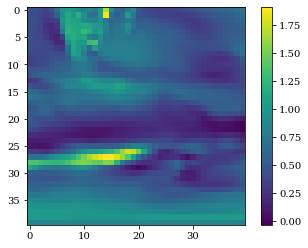

In [23]:
plt.colorbar(plt.imshow(pred.numpy()[0, ::-1]))

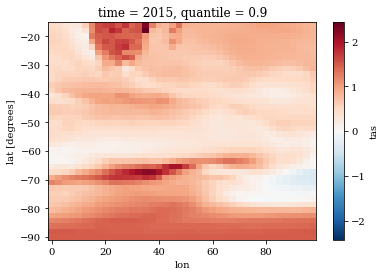

In [24]:
outputs['ssp245'].tas.mean('member').isel(time=0).plot()

In [32]:
test_times = test_scenarios.timesteps
test_tas = test_scenarios.tas

test_tas_fair = model._compute_mean(test_scenarios)

with torch.no_grad():
    test_prior = model.forward(test_scenarios)
    noisy_test_prior = likelihood(test_prior)

prior_mean = noisy_test_prior.mean + test_tas_fair
prior_lb, prior_ub = noisy_test_prior.confidence_region()
prior_lb = prior_lb + test_tas_fair
prior_ub = prior_ub + test_tas_fair

posterior_mean = noisy_pred.mean + test_tas_fair
posterior_lb, posterior_ub = noisy_pred.confidence_region()
posterior_lb = posterior_lb + test_tas_fair
posterior_ub = posterior_ub + test_tas_fair

In [33]:
pattern = torch.from_numpy(pattern_tas.values)

In [34]:
spatial_posterior_mean = (pattern.unsqueeze(-1) * posterior_mean.div(pattern_glob_tas))
spatial_posterior_ub = (pattern.unsqueeze(-1) * posterior_ub.div(pattern_glob_tas))
spatial_posterior_lb = (pattern.unsqueeze(-1) * posterior_lb.div(pattern_glob_tas))
spatial_posterior_mean = spatial_posterior_mean.permute(2, 0, 1).numpy()
spatial_posterior_ub = spatial_posterior_ub.permute(2, 0, 1).numpy()
spatial_posterior_lb = spatial_posterior_lb.permute(2, 0, 1).numpy()


all_values = np.concatenate([spatial_posterior_mean, spatial_posterior_ub, spatial_posterior_lb])
vmax = all_values.max()
vmin = -vmax
cmap = 'coolwarm'

In [41]:
outputs['ssp245'].mean('member').tas.values.squeeze()[step]

array([[1.4760233, 1.475942 , 1.4758759, ..., 1.4758148, 1.476008 ,
        1.4759165],
       [1.4967753, 1.4923553, 1.487966 , ..., 1.4924469, 1.4965872,
        1.4982758],
       [1.3206991, 1.3351593, 1.3497111, ..., 1.2815399, 1.2928162,
        1.3042246],
       ...,
       [2.0209656, 2.0197754, 2.0215454, ..., 2.0249023, 2.018687 ,
        2.0193074],
       [2.1650493, 2.163503 , 2.162557 , ..., 2.1630657, 2.1640117,
        2.1645   ],
       [2.2874348, 2.284251 , 2.279073 , ..., 2.2859294, 2.2864177,
        2.286794 ]], dtype=float32)

IndexError: index 4 is out of bounds for axis 0 with size 4

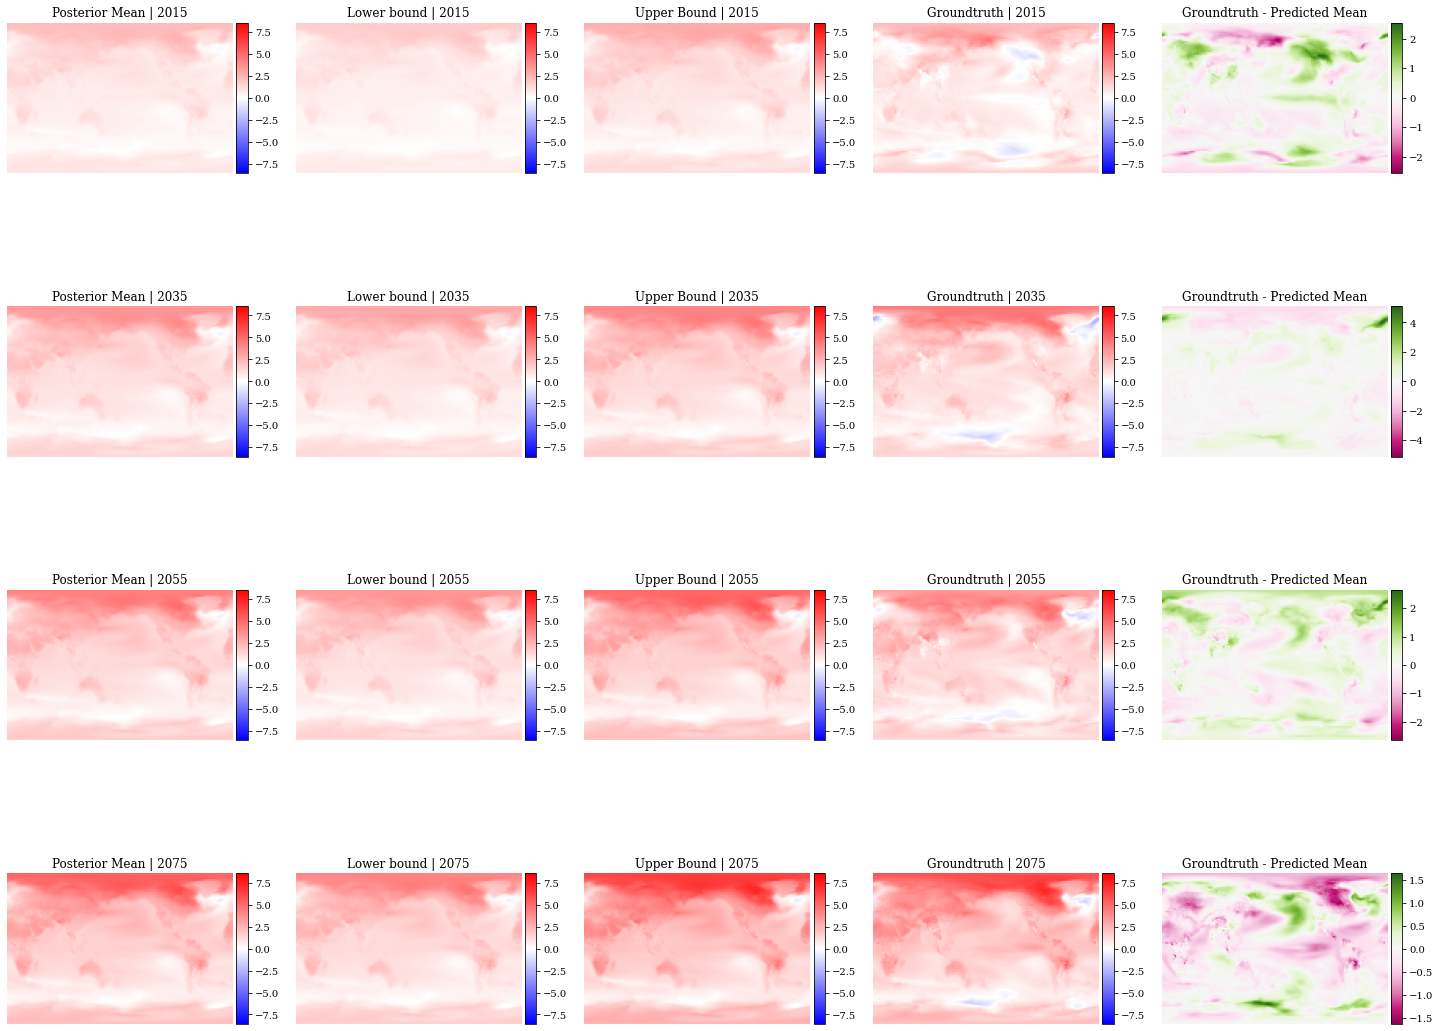

In [44]:
step_size = 20
nrow = prior_mean.size(0) // step_size
ncol = 5

spatial_posterior_mean = (pattern.unsqueeze(-1) * posterior_mean.div(pattern_glob_tas))
spatial_posterior_ub = (pattern.unsqueeze(-1) * posterior_ub.div(pattern_glob_tas))
spatial_posterior_lb = (pattern.unsqueeze(-1) * posterior_lb.div(pattern_glob_tas))
spatial_posterior_mean = spatial_posterior_mean.permute(2, 0, 1).numpy()
spatial_posterior_ub = spatial_posterior_ub.permute(2, 0, 1).numpy()
spatial_posterior_lb = spatial_posterior_lb.permute(2, 0, 1).numpy()


all_values = np.concatenate([spatial_posterior_mean, spatial_posterior_ub, spatial_posterior_lb])
vmax = all_values.max()
vmin = -vmax
cmap = 'bwr'

fig, ax = plt.subplots(nrow, ncol, figsize=(5 * ncol, 5 * nrow))

for idx, step in enumerate(range(0, prior_mean.size(0), step_size)):
    im = ax[idx, 0].imshow(spatial_posterior_mean[step, ::-1], vmin=vmin, vmax=vmax, cmap=cmap)
    colorbar(im)
    ax[idx, 0].axis('off')
    ax[idx, 0].set_title(f'Posterior Mean | {test_times[step].int().item()}')
    
    im = ax[idx, 1].imshow(spatial_posterior_lb[step, ::-1], vmin=vmin, vmax=vmax, cmap=cmap)
    colorbar(im)
    ax[idx, 1].axis('off')
    ax[idx, 1].set_title(f'Lower bound | {test_times[step].int().item()}')
    
    im = ax[idx, 2].imshow(spatial_posterior_ub[step, ::-1], vmin=vmin, vmax=vmax, cmap=cmap)
    colorbar(im)
    ax[idx, 2].axis('off')
    ax[idx, 2].set_title(f'Upper Bound | {test_times[step].int().item()}')
    
    gt = outputs['ssp245'].mean('member').tas.values.squeeze()[step]   
    im = ax[idx, 3].imshow(gt[::-1], vmin=vmin, vmax=vmax, cmap=cmap)
    colorbar(im)
    ax[idx, 3].axis('off')
    ax[idx, 3].set_title(f'Groundtruth | {test_times[step].int().item()}')
    
    diff = spatial_posterior_mean[step] - gt
    diffmax = np.abs(diff).max()
    im = ax[idx, 4].imshow(diff[::-1], vmin=-diffmax, vmax=diffmax, cmap='PiYG')
    colorbar(im)
    ax[idx, 4].axis('off')
    ax[idx, 4].set_title('Groundtruth - Predicted Mean')
    
    
plt.tight_layout()
plt.show()

In [103]:
rbf = kernels.RBFKernel()
linear = kernels.LinearKernel()
lbda = 0.1
X = torch.randn(100)
Z = torch.randn(200)

In [104]:
with torch.no_grad():
    Krbf = rbf(X).add_jitter().evaluate()
    Klin = linear(Z).add_jitter().evaluate()

    R = torch.kron(Krbf, Klin) + lbda * torch.eye(X.size(0) * Z.size(0))

In [ ]:
%%time
R_inv = R.inverse()

In [100]:
%%time
Lrbf, Qrbf = torch.linalg.eigh(Krbf)
Lrbf, Qrbf = torch.real(Lrbf), torch.real(Qrbf)

# This can be faster
Llin, Qlin = torch.linalg.eigh(Klin)
Llin, Qlin = torch.real(Llin), torch.real(Qlin)

Lbda = torch.kron(Lrbf, Llin) + lbda
Qrbf_kron_Qlin = torch.kron(Qrbf, Qlin)
S = Qrbf_kron_Qlin.mul(1 / Lbda) @ Qrbf_kron_Qlin.t()

130 ms ± 9.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


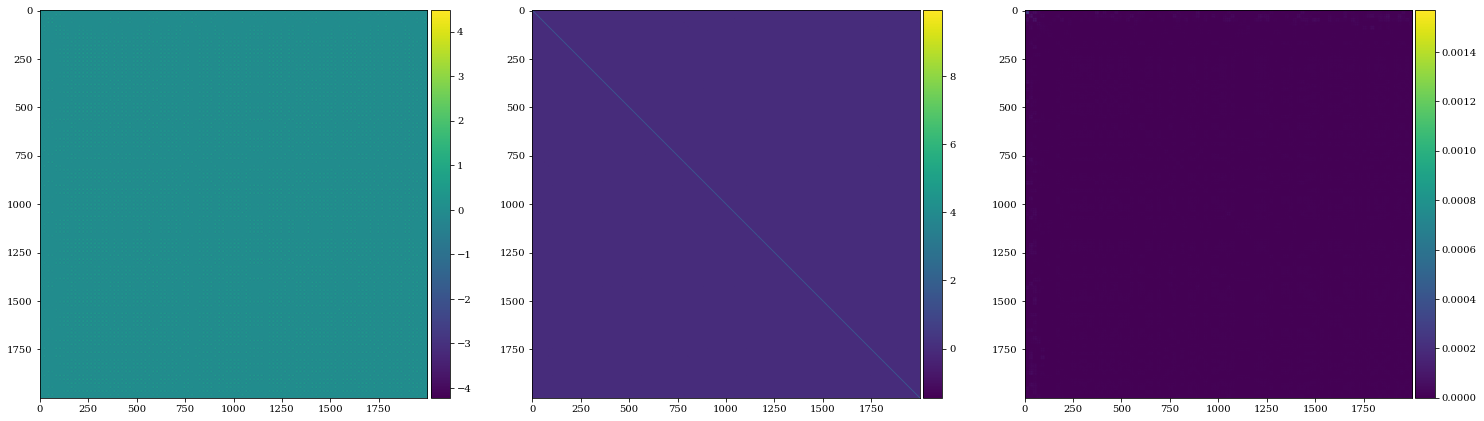

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(25, 10))

im = ax[0].imshow(S)
colorbar(im)
im = ax[1].imshow(R_inv)
colorbar(im)
im = ax[2].imshow(torch.abs(S - R_inv))
colorbar(im)

In [86]:
torch.allclose(S, R_inv, atol=1e-4, rtol=1)

True